In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
df = pd.read_csv('dataset/train.csv')
df = df.drop(columns='id')

count    20758.000000
mean        30.241842
std          8.333932
min         12.868541
25%         24.088223
50%         29.384757
75%         37.011168
max         54.997991
Name: BMI, dtype: float64

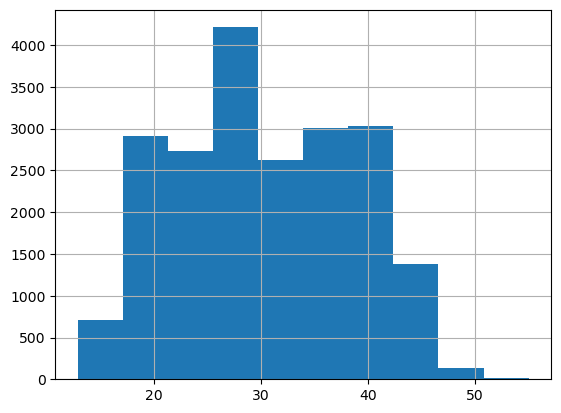

In [5]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'].hist()
df['BMI'].describe()

In [6]:
df['Age'].describe()

count    20758.000000
mean        23.841804
std          5.688072
min         14.000000
25%         20.000000
50%         22.815416
75%         26.000000
max         61.000000
Name: Age, dtype: float64

In [7]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [8]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]
WHObmi_boys

,Age,Month,L,M,S,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
107,14.000000,168,-1.6211,19.0050,0.12191,14.163,15.050,15.639,15.976,16.534,16.941,17.593,19.005,20.758,21.891,22.757,24.221,25.315,27.786,34.011
108,14.083333,169,-1.6116,19.0701,0.12212,14.201,15.093,15.685,16.024,16.586,16.995,17.651,19.070,20.832,21.970,22.839,24.309,25.406,27.882,34.107
109,14.166667,170,-1.6020,19.1351,0.12233,14.239,15.136,15.731,16.073,16.638,17.049,17.708,19.135,20.906,22.049,22.921,24.396,25.496,27.979,34.202
110,14.250000,171,-1.5921,19.2000,0.12253,14.276,15.178,15.778,16.121,16.689,17.103,17.766,19.200,20.979,22.127,23.003,24.482,25.586,28.073,34.292
111,14.333333,172,-1.5821,19.2648,0.12272,14.314,15.221,15.824,16.169,16.741,17.157,17.823,19.265,21.052,22.204,23.084,24.568,25.674,28.165,34.378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,18.666667,224,-0.9048,22.0374,0.12911,15.675,16.895,17.694,18.147,18.889,19.422,20.265,22.037,24.130,25.416,26.364,27.898,28.990,31.288,36.151
164,18.750000,225,-0.8892,22.0760,0.12920,15.687,16.914,17.716,18.171,18.916,19.452,20.299,22.076,24.172,25.459,26.406,27.939,29.028,31.318,36.150
165,18.833333,226,-0.8735,22.1140,0.12930,15.697,16.931,17.738,18.195,18.943,19.482,20.331,22.114,24.214,25.501,26.449,27.980,29.067,31.349,36.149
166,18.916667,227,-0.8578,22.1514,0.12939,15.707,16.948,17.759,18.218,18.970,19.511,20.363,22.151,24.255,25.543,26.490,28.019,29.103,31.378,36.147


In [9]:
WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]
WHObmi_girls

,Age,Month,L,M,S,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
107,14.000000,168,-1.2266,19.5647,0.13700,13.912,14.950,15.640,16.035,16.688,17.164,17.925,19.565,21.581,22.868,23.842,25.470,26.667,29.311,35.549
108,14.083333,169,-1.2186,19.6240,0.13719,13.943,14.987,15.680,16.077,16.734,17.212,17.977,19.624,21.648,22.940,23.918,25.550,26.750,29.398,35.634
109,14.166667,170,-1.2107,19.6824,0.13738,13.973,15.023,15.720,16.119,16.779,17.259,18.028,19.682,21.715,23.012,23.992,25.629,26.832,29.484,35.719
110,14.250000,171,-1.2027,19.7400,0.13756,14.003,15.058,15.759,16.160,16.823,17.306,18.078,19.740,21.781,23.082,24.065,25.707,26.912,29.568,35.799
111,14.333333,172,-1.1947,19.7966,0.13774,14.033,15.093,15.797,16.200,16.867,17.352,18.127,19.797,21.845,23.151,24.137,25.783,26.991,29.650,35.877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,18.666667,224,-0.7819,21.3752,0.14405,14.589,15.873,16.718,17.199,17.990,18.560,19.464,21.375,23.648,25.053,26.091,27.779,28.982,31.526,36.943
164,18.750000,225,-0.7738,21.3884,0.14414,14.587,15.875,16.722,17.204,17.997,18.569,19.475,21.388,23.663,25.068,26.106,27.793,28.995,31.533,36.929
165,18.833333,226,-0.7658,21.4014,0.14423,14.585,15.876,16.726,17.210,18.004,18.577,19.485,21.401,23.678,25.084,26.121,27.807,29.007,31.540,36.917
166,18.916667,227,-0.7577,21.4143,0.14432,14.583,15.878,16.730,17.215,18.011,18.585,19.495,21.414,23.693,25.099,26.136,27.820,29.019,31.547,36.903


In [10]:
CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]
CDCbmi_boys

,Age,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P85,P90,P95,P97
145,14.041667,1,168.5,-2.227362,19.157587,0.135251,15.660756,15.990651,16.545676,17.630859,19.157587,21.214326,22.663251,23.848867,26.046622,27.884411
146,14.125000,1,169.5,-2.219280,19.215577,0.135281,15.705363,16.036668,16.594004,17.683468,19.215577,21.278115,22.729928,23.917061,26.115349,27.951025
147,14.208333,1,170.5,-2.211240,19.273658,0.135302,15.750195,16.082901,16.642535,17.736241,19.273658,21.341854,22.796429,23.984961,26.183529,28.016859
148,14.291667,1,171.5,-2.203239,19.331822,0.135316,15.795241,16.129342,16.691259,17.789171,19.331822,21.405538,22.862751,24.052565,26.251170,28.081928
149,14.375000,1,172.5,-2.195272,19.390061,0.135321,15.840490,16.175979,16.740165,17.842246,19.390061,21.469161,22.928892,24.119875,26.318276,28.146245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,19.791667,1,237.5,-1.837119,22.912932,0.133930,18.628251,19.043431,19.737332,21.075788,22.912932,25.291785,26.895069,28.159783,30.387967,32.133482
215,19.875000,1,238.5,-1.838987,22.956264,0.134160,18.658612,19.074844,19.770595,21.112962,22.956264,25.344588,26.955297,28.226503,30.467579,32.224572
216,19.958333,1,239.5,-1.841146,22.999081,0.134408,18.688222,19.105507,19.803121,21.149457,22.999081,25.397250,27.015751,28.293813,30.548594,32.317868
217,20.000000,1,240.0,-1.842330,23.020294,0.134539,18.702737,19.120551,19.819101,21.167446,23.020294,25.423529,27.046068,28.327698,30.589643,32.365366


In [11]:
CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]
CDCbmi_girls

,Age,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P85,P90,P95,P97
145,14.041667,2,168.5,-1.977074,19.352572,0.151256,15.442351,15.807529,16.423776,17.635089,19.352572,21.688194,23.346890,24.711407,27.255974,29.396856
146,14.125000,2,169.5,-1.980633,19.402447,0.151235,15.483743,15.849637,16.467122,17.680995,19.402447,21.744257,23.408011,24.777163,27.331667,29.482372
147,14.208333,2,170.5,-1.984438,19.452045,0.151206,15.525167,15.891747,16.510421,17.726755,19.452045,21.799888,23.468611,24.842343,27.406734,29.567285
148,14.291667,2,171.5,-1.988483,19.501355,0.151169,15.566609,15.933846,16.553658,17.772357,19.501355,21.855078,23.528685,24.906944,27.481176,29.651603
149,14.375000,2,172.5,-1.992764,19.550369,0.151123,15.608054,15.975918,16.596819,17.817789,19.550369,21.909821,23.588227,24.970963,27.554998,29.735333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,19.791667,2,237.5,-2.353501,21.689489,0.151755,17.435152,17.822557,18.480142,19.788872,21.689489,24.384258,26.397231,28.130338,31.596640,34.818095
215,19.875000,2,238.5,-2.350529,21.701083,0.152221,17.434275,17.822591,18.481819,19.794202,21.701083,24.406856,26.429839,28.172905,31.663237,34.912504
216,19.958333,2,239.5,-2.346962,21.711892,0.152716,17.431988,17.821267,18.482230,19.798457,21.711892,24.429104,26.462429,28.215745,31.730686,35.008306
217,20.000000,2,240.0,-2.344958,21.716999,0.152975,17.430311,17.820090,18.481956,19.800176,21.716999,24.440096,26.478720,28.237271,31.764743,35.056751


In [12]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [13]:
CDCbmi_boys.loc[(CDCbmi_boys.Age - 18.128249).abs().idxmin()]

Age        18.125000
Sex         1.000000
Agemos    217.500000
L          -1.869760
M          21.948362
S           0.132260
P3         17.893295
P5         18.286457
P10        18.943423
P25        20.210224
P50        21.948362
P75        24.198409
P85        25.714806
P90        26.911086
P95        29.019211
P97        30.671372
Name: 194, dtype: float64

In [14]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
df_temp

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,Adult BMI Predictions
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,False,N/A
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,False,N/A
5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,16.861932,False,N/A
8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I,24.221453,False,N/A
12,Male,18.000000,1.811189,108.251044,yes,yes,2.000000,2.164839,Sometimes,no,2.530157,no,1.000000,0.553311,no,Public_Transportation,Obesity_Type_I,32.999286,False,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20743,Female,19.000000,1.740000,78.000000,yes,yes,3.000000,1.000000,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_I,25.762981,False,N/A
20745,Female,19.979810,1.742901,49.932199,no,yes,2.969233,3.489918,Frequently,no,2.721769,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,16.437481,False,N/A
20746,Female,18.000000,1.610000,64.000000,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,1.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight,24.690405,False,N/A
20750,Male,18.827008,1.753321,80.000000,yes,yes,2.826251,2.256119,Sometimes,no,2.137550,no,0.753782,0.051858,no,Public_Transportation,Overweight_Level_I,26.023585,False,N/A


In [15]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693,True,overweight,N/A,N/A


In [16]:
df[df['Adult'] == "False"].describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000,5140.000000
mean,18.226554,1.696695,69.995443,2.369779,2.866224,1.908809,1.240374,0.835922,24.125985
std,0.878565,0.090273,24.657425,0.562437,0.763374,0.605731,0.804580,0.595997,7.542905
min,14.000000,1.456346,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.929102
25%,18.000000,1.620000,50.973587,2.000000,3.000000,1.448875,0.978594,0.152481,17.826896
50%,18.000000,1.700000,60.000000,2.000000,3.000000,2.000000,1.000000,1.000000,22.204082
75%,19.000000,1.761199,83.000000,3.000000,3.000000,2.000000,2.000000,1.000000,27.717685
max,19.994543,1.975663,160.935351,3.000000,4.000000,3.000000,3.000000,2.000000,52.476283


In [17]:
df[df['WHO BMI Predictions'] != df['CDC BMI Predictions']]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
35,Female,18.634286,1.692646,79.697278,no,yes,1.989899,1.893811,Sometimes,no,...,1.000000,0.704978,Sometimes,Public_Transportation,Overweight_Level_I,27.817059,False,N/A,obseity class 1,overweight
44,Male,19.000000,1.740000,78.000000,yes,no,3.000000,3.000000,Sometimes,no,...,1.000000,0.000000,no,Public_Transportation,Overweight_Level_II,25.762981,False,N/A,overweight,healthy
55,Male,18.000000,1.743790,54.835576,yes,yes,2.263245,2.473913,Sometimes,no,...,0.282063,0.000000,no,Public_Transportation,Insufficient_Weight,18.033252,False,N/A,healthy,underweight
67,Male,17.000000,1.800000,91.000000,yes,yes,2.000000,3.000000,Sometimes,no,...,1.000000,1.000000,Sometimes,Public_Transportation,Overweight_Level_II,28.086420,False,N/A,obseity class 1,overweight
93,Female,18.000000,1.700000,50.000000,yes,yes,1.000000,3.000000,Frequently,no,...,0.000000,2.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.301038,False,N/A,healthy,underweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20716,Female,18.871794,1.536819,41.669346,yes,yes,2.652779,1.079760,Sometimes,no,...,0.194745,1.672532,Sometimes,Public_Transportation,Insufficient_Weight,17.642952,False,N/A,healthy,underweight
20730,Male,19.000000,1.800000,85.000000,yes,no,3.000000,3.000000,Sometimes,no,...,2.000000,1.000000,Sometimes,Public_Transportation,Overweight_Level_I,26.234568,False,N/A,overweight,healthy
20742,Female,19.637947,1.718890,51.149283,yes,yes,3.000000,3.000000,Frequently,no,...,1.926592,0.805008,no,Public_Transportation,Insufficient_Weight,17.311846,False,N/A,healthy,underweight
20743,Female,19.000000,1.740000,78.000000,yes,yes,3.000000,1.000000,Sometimes,no,...,1.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_I,25.762981,False,N/A,overweight,healthy


In [18]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.42 Mb (30.7% reduction)
memory GB:0.24
Memory reduced


features obtained


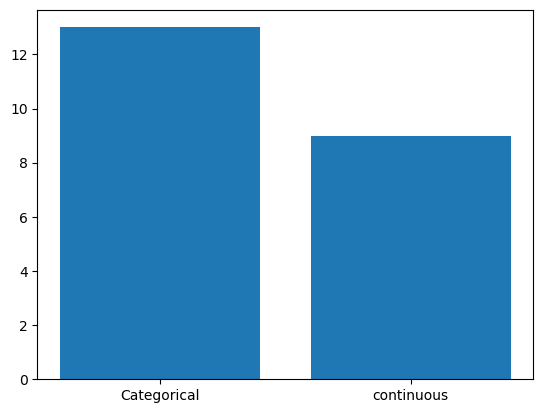

CPU times: total: 93.8 ms
Wall time: 81.5 ms


In [19]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [20]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', df_lean.shape)
# print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (df_lean.isnull().values.sum())
# test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/df_lean.shape[0]))
# print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(df_lean.info(),'\n')
# print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column #,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (20758, 22)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  13
Continuous features :  9
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 n

In [21]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [22]:
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [23]:
for cat_feat in cat_features:
    print(df[cat_feat].unique())

['Male' 'Female']
['yes' 'no']
['yes' 'no']
['Sometimes' 'Frequently' 'no' 'Always']
['no' 'yes']
['no' 'yes']
['Sometimes' 'no' 'Frequently']
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']
['True' 'False']
['overweight' 'N/A' 'obseity class 3' 'obseity class 2' 'healthy'
 'obseity class 1' 'underweight']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [24]:
nominal_features = [cat_features[i] for i in [0, 1, 2, 4, 5, 7, 9]]
print(nominal_features)
print()
for cat_feat in nominal_features:
    print(df[cat_feat].unique())

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS', 'Adult']

['Male' 'Female']
['yes' 'no']
['yes' 'no']
['no' 'yes']
['no' 'yes']
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['True' 'False']


In [25]:
ordinal_features = [cat_features[i] for i in [3, 6, 10, 11, 12]]
print(ordinal_features)
print()
for cat_feat in ordinal_features:
    print(df[cat_feat].unique())

['CAEC', 'CALC', 'Adult BMI Predictions', 'WHO BMI Predictions', 'CDC BMI Predictions']

['Sometimes' 'Frequently' 'no' 'Always']
['Sometimes' 'no' 'Frequently']
['overweight' 'N/A' 'obseity class 3' 'obseity class 2' 'healthy'
 'obseity class 1' 'underweight']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [26]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693,True,overweight,N/A,N/A


In [27]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,no,1.000000,1.000000,no,Automobile,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,no,0.866045,1.673584,no,Public_Transportation,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,no,1.158040,1.198439,no,Public_Transportation,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,no,0.000000,0.973834,no,Automobile,28.899693,True,overweight,N/A,N/A


In [28]:
# Manual encoding
manual_enc = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ]
)
    
X_enc = manual_enc.fit_transform(X, y)
X_enc

,numerical__Age,numerical__Height,numerical__Weight,numerical__FCVC,numerical__NCP,numerical__CH2O,numerical__FAF,numerical__TUE,numerical__BMI,ordinal__CAEC,...,nominal__SMOKE_yes,nominal__SCC_no,nominal__SCC_yes,nominal__MTRANS_Automobile,nominal__MTRANS_Bike,nominal__MTRANS_Motorbike,nominal__MTRANS_Public_Transportation,nominal__MTRANS_Walking,nominal__Adult_False,nominal__Adult_True
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,28.899693,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
manual_enc.get_params()['ordinal'].categories

[['no', 'Sometimes', 'Frequently', 'Always'],
 ['no', 'Sometimes', 'Frequently'],
 ['N/A',
  'underweight',
  'healthy',
  'overweight',
  'obseity class 1',
  'obseity class 2',
  'obseity class 3'],
 ['N/A',
  'underweight',
  'healthy',
  'overweight',
  'obseity class 1',
  'obseity class 2',
  'obseity class 3'],
 ['N/A',
  'underweight',
  'healthy',
  'overweight',
  'obseity class 1',
  'obseity class 2',
  'obseity class 3']]

In [30]:
X_enc.iloc[:, 9:14]

,ordinal__CAEC,ordinal__CALC,ordinal__Adult BMI Predictions,ordinal__WHO BMI Predictions,ordinal__CDC BMI Predictions
0,1.0,1.0,3.0,0.0,0.0
1,2.0,0.0,0.0,2.0,2.0
2,1.0,0.0,0.0,1.0,1.0
3,1.0,1.0,6.0,0.0,0.0
4,1.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...
20753,1.0,1.0,5.0,0.0,0.0
20754,2.0,1.0,0.0,1.0,1.0
20755,1.0,0.0,4.0,0.0,0.0
20756,1.0,0.0,3.0,0.0,0.0


In [31]:
X_enc.iloc[:, 15:]

,nominal__Gender_Male,nominal__family_history_with_overweight_no,nominal__family_history_with_overweight_yes,nominal__FAVC_no,nominal__FAVC_yes,nominal__SMOKE_no,nominal__SMOKE_yes,nominal__SCC_no,nominal__SCC_yes,nominal__MTRANS_Automobile,nominal__MTRANS_Bike,nominal__MTRANS_Motorbike,nominal__MTRANS_Public_Transportation,nominal__MTRANS_Walking,nominal__Adult_False,nominal__Adult_True
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20754,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20755,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20756,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
manual_enc.transformers

[('numerical',
  'passthrough',
  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']),
 ('ordinal',
  OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently', 'Always'],
                             ['no', 'Sometimes', 'Frequently'],
                             ['N/A', 'underweight', 'healthy', 'overweight',
                              'obseity class 1', 'obseity class 2',
                              'obseity class 3'],
                             ['N/A', 'underweight', 'healthy', 'overweight',
                              'obseity class 1', 'obseity class 2',
                              'obseity class 3'],
                             ['N/A', 'underweight', 'healthy', 'overweight',
                              'obseity class 1', 'obseity class 2',
                              'obseity class 3']]),
  ['CAEC',
   'CALC',
   'Adult BMI Predictions',
   'WHO BMI Predictions',
   'CDC BMI Predictions']),
 ('nominal',
  OneHotEncoder(sparse_output=False),

In [33]:
manual_enc.output_indices_

{'numerical': slice(0, 9, None),
 'ordinal': slice(9, 14, None),
 'nominal': slice(14, 31, None),
 'remainder': slice(0, 0, None)}

In [34]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,no,1.000000,1.000000,no,Automobile,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,no,0.866045,1.673584,no,Public_Transportation,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,no,1.158040,1.198439,no,Public_Transportation,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,no,0.000000,0.973834,no,Automobile,28.899693,True,overweight,N/A,N/A


In [35]:
# Manual encoding
col_enc1 = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [36]:
col_enc2 = ColumnTransformer(
    [
        ('numerIteract', Pipeline(
            [
                ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                ('scale', StandardScaler())
            ]), slice(0, 9)),
        ('catInteract', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), slice(14, 31))
    ], verbose_feature_names_out=False
)

manual_enc2 = Pipeline([('Categorical Preprocessing', col_enc1), ('Interaction Terms', col_enc2)])
    
X_enc2 = manual_enc2.fit_transform(X.copy(), y)
X_enc2

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult_False,MTRANS_Motorbike Adult_True,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult_False,MTRANS_Public_Transportation Adult_True,MTRANS_Walking Adult_False,MTRANS_Walking Adult_True,Adult_False Adult_True
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0.104173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,-1.269171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,-0.991274,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,-0.477718,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,2.042301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0.395166,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,-0.993953,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,-0.403258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,1.734782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,no,1.000000,1.000000,no,Automobile,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,no,0.866045,1.673584,no,Public_Transportation,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,no,1.158040,1.198439,no,Public_Transportation,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,no,0.000000,0.973834,no,Automobile,28.899693,True,overweight,N/A,N/A


In [38]:
X_enc2.iloc[:, 3].describe()

count    2.075800e+04
mean     2.427442e-14
std      1.000024e+00
min     -2.711729e+00
25%     -8.362790e-01
50%     -9.765730e-02
75%      1.039171e+00
max      1.039171e+00
Name: FCVC, dtype: float64

In [39]:
y

0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [62]:
X_enc['Gender']

KeyError: 'Gender'

In [40]:
def eval_cluster(y_true, y_pred):
    scores = [fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score]
    names = ["fowlkes_mallows_score", "homogeneity_completeness_v_measure", "adjusted_mutual_info_score", "normalized_mutual_info_score", "adjusted_rand_score", "rand_score"]
    for score, name in zip(scores, names):
        print(f"{name}: {score(y_true, y_pred)}")

In [41]:
KM = KMeans().fit_predict(X_enc2, y)
pd.Series(KM).describe()
print()
eval_cluster(KM, y)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



fowlkes_mallows_score: 0.37839247962646005
homogeneity_completeness_v_measure: (0.34873393056744756, 0.3687519440241884, 0.35846368381017807)
adjusted_mutual_info_score: 0.3581365417153971
normalized_mutual_info_score: 0.35846368381017807
adjusted_rand_score: 0.27624061487275414
rand_score: 0.8247341171628335


In [42]:
KMpp = KMeans(init='k-means++').fit_predict(X_enc2, y)
pd.Series(KMpp).describe()
print()
eval_cluster(KMpp, y)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



fowlkes_mallows_score: 0.3784189846392522
homogeneity_completeness_v_measure: (0.34892179810256624, 0.3689334219303834, 0.3586486783621172)
adjusted_mutual_info_score: 0.35832162273440676
normalized_mutual_info_score: 0.3586486783621172
adjusted_rand_score: 0.2762624994451327
rand_score: 0.8247276048152252


In [43]:
GaussMix = GaussianMixture(n_components=7).fit_predict(X_enc2, y)
pd.Series(GaussMix).describe()
print()
eval_cluster(GaussMix, y)


fowlkes_mallows_score: 0.4247663933841247
homogeneity_completeness_v_measure: (0.3734046749162128, 0.32794629436773143, 0.3492022818857256)
adjusted_mutual_info_score: 0.34889057590695227
normalized_mutual_info_score: 0.3492022818857256
adjusted_rand_score: 0.2955460329535948
rand_score: 0.7910918585754085


In [44]:
BayesGaussMix = BayesianGaussianMixture(n_components=7).fit_predict(X_enc2, y)
pd.Series(BayesGaussMix).describe()
print()
eval_cluster(BayesGaussMix, y)


fowlkes_mallows_score: 0.3247532296859279
homogeneity_completeness_v_measure: (0.3037932979618238, 0.24777346545154255, 0.2729385568888687)
adjusted_mutual_info_score: 0.272578249406453
normalized_mutual_info_score: 0.27293855688886864
adjusted_rand_score: 0.15434043912838205
rand_score: 0.7223391156899429


In [45]:
BSKM = BisectingKMeans().fit_predict(X_enc2, y)
pd.Series(BSKM).describe()
print()
eval_cluster(BSKM, y)


fowlkes_mallows_score: 0.4704076433480639
homogeneity_completeness_v_measure: (0.37275464283161064, 0.3912347300309308, 0.3817711796424165)
adjusted_mutual_info_score: 0.38145471581216095
normalized_mutual_info_score: 0.3817711796424165
adjusted_rand_score: 0.3815607392672322
rand_score: 0.8479655595494705


In [46]:
## Hmm, wonder if overfitting...

In [47]:
BSKM2 = BisectingKMeans().fit_predict(X_enc, y)
pd.Series(BSKM2).describe()
print()
eval_cluster(BSKM2, y)


fowlkes_mallows_score: 0.4586236151940862
homogeneity_completeness_v_measure: (0.525444296732418, 0.543267545814587, 0.5342072992618441)
adjusted_mutual_info_score: 0.5339670183073318
normalized_mutual_info_score: 0.5342072992618441
adjusted_rand_score: 0.36499096256802793
rand_score: 0.8403472361464461


In [48]:
BSKM3 = BisectingKMeans().fit_predict(OrdinalEncoder().fit_transform(X.copy(), y), y)
pd.Series(BSKM3).describe()
print()
eval_cluster(BSKM3, y)


fowlkes_mallows_score: 0.5433201852840124
homogeneity_completeness_v_measure: (0.5928962798522349, 0.618825893320105, 0.605583653000535)
adjusted_mutual_info_score: 0.6053811739059439
normalized_mutual_info_score: 0.605583653000535
adjusted_rand_score: 0.46600996058064625
rand_score: 0.8678524170949486


In [49]:
BSKM4 = BisectingKMeans().fit_predict(StandardScaler().fit_transform(OrdinalEncoder().fit_transform(X.copy(), y), y), y)
pd.Series(BSKM4).describe()
print()
eval_cluster(BSKM4, y)


fowlkes_mallows_score: 0.5168857081889361
homogeneity_completeness_v_measure: (0.40166298620675983, 0.4176943291127558, 0.40952182501143425)
adjusted_mutual_info_score: 0.4092181253176013
normalized_mutual_info_score: 0.4095218250114343
adjusted_rand_score: 0.4344394793483174
rand_score: 0.8591721307839261


In [50]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,Adult BMI Predictions,WHO BMI Predictions,CDC BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565,True,overweight,N/A,N/A
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,no,1.000000,1.000000,no,Automobile,23.422091,False,N/A,healthy,healthy
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,no,0.866045,1.673584,no,Public_Transportation,17.126706,False,N/A,underweight,underweight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798,True,obseity class 3,N/A,N/A
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151,True,overweight,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,...,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084,True,obseity class 2,N/A,N/A
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,...,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278,False,N/A,underweight,underweight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,...,no,1.158040,1.198439,no,Public_Transportation,31.889841,True,obseity class 1,N/A,N/A
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,...,no,0.000000,0.973834,no,Automobile,28.899693,True,overweight,N/A,N/A


In [51]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [52]:
preprocessed = ['Ordinal', 'Manual Encoding', "Enc + Pairwise"]

In [53]:
X_s = [OrdinalEncoder().fit_transform(X.copy()), X_enc, X_enc2]

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=1/3, random_state=42)

In [54]:
# Model 1 - Decision Tree
test = []
models = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"Decision Tree {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Decision Tree Ordinal
training time 0.188 s
predict time 0.006 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.8391618497109826, AUC_ROC_OVO: 0.8961243240077637, AUC_ROC_OVR: 0.8977312961674692

Decision Tree Manual Encoding
training time 0.197 s
predict time 0.008 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.8378612716763005, AUC_ROC_OVO: 0.8954151997482276, AUC_ROC_OVR: 0.8970192480736197

Decision Tree Enc + Pairwise
training time 1.514 s
predict time 0.023 s
Confusion matrix: 
TRAIN - Accuracy: 0.9992050874403816, AUC_ROC_OVO: 0.9999995106717039, AUC_ROC_OVR: 0.9999995745812212
TEST - Accuracy: 0.8286127167630057, AUC_ROC_OVO: 0.8900504011685968, AUC_ROC_OVR: 0.891700273234919

Best Preprocessing: Ordinal - Test Accuracy: 0.8391618497109826


In [55]:
# Model 2a - Logistic Regression
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Logistic Regression Ordinal


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


training time 12.226 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 0.8298887122416534, AUC_ROC_OVO: 0.9675872821658935, AUC_ROC_OVR: 0.9708300181562972
TEST - Accuracy: 0.8281791907514451, AUC_ROC_OVO: 0.9670783465257955, AUC_ROC_OVR: 0.9703061590913303

Logistic Regression Manual Encoding


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


training time 13.037 s
predict time 0.004 s
Confusion matrix: 
TRAIN - Accuracy: 0.8678277207688972, AUC_ROC_OVO: 0.9779857865253669, AUC_ROC_OVR: 0.9802927638081128
TEST - Accuracy: 0.8630057803468208, AUC_ROC_OVO: 0.9773942507230406, AUC_ROC_OVR: 0.9797176023214416

Logistic Regression Enc + Pairwise
training time 6.364 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.8764272293684059, AUC_ROC_OVO: 0.9803141080410617, AUC_ROC_OVR: 0.982428514881814
TEST - Accuracy: 0.867485549132948, AUC_ROC_OVO: 0.977683089209141, AUC_ROC_OVR: 0.9800117267422153

Best Preprocessing: Enc + Pairwise - Test Accuracy: 0.867485549132948


In [56]:
# Model 6a - LDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i].to_records(), y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

LDA Ordinal
training time 0.057 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 0.8200607024136436, AUC_ROC_OVO: 0.9670042185158944, AUC_ROC_OVR: 0.9707505261817377
TEST - Accuracy: 0.8236994219653179, AUC_ROC_OVO: 0.966802285185989, AUC_ROC_OVR: 0.9705597806994541

LDA Manual Encoding
training time 0.104 s
predict time 0.006 s
Confusion matrix: 
TRAIN - Accuracy: 0.8212892036421449, AUC_ROC_OVO: 0.9702588923781965, AUC_ROC_OVR: 0.9734176164249035
TEST - Accuracy: 0.8216763005780346, AUC_ROC_OVO: 0.9706266973984564, AUC_ROC_OVR: 0.9737613166978666

LDA Enc + Pairwise
training time 0.627 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.8484607602254661, AUC_ROC_OVO: 0.9744137297465839, AUC_ROC_OVR: 0.9770512060208258
TEST - Accuracy: 0.8440751445086705, AUC_ROC_OVO: 0.9732026273232917, AUC_ROC_OVR: 0.9760324500392306

Best Preprocessing: Enc + Pairwise - Test Accuracy: 0.8440751445086705


In [57]:
X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult_False,MTRANS_Motorbike Adult_True,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult_False,MTRANS_Public_Transportation Adult_True,MTRANS_Walking Adult_False,MTRANS_Walking Adult_True,Adult_False Adult_True
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0.104173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,-1.269171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,-0.991274,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,-0.477718,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,2.042301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0.395166,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,-0.993953,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,-0.403258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,1.734782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
test = X_enc.columns[0]
for name in X_enc.columns:
    print(name.split('__'))

['numerical', 'Age']
['numerical', 'Height']
['numerical', 'Weight']
['numerical', 'FCVC']
['numerical', 'NCP']
['numerical', 'CH2O']
['numerical', 'FAF']
['numerical', 'TUE']
['numerical', 'BMI']
['ordinal', 'CAEC']
['ordinal', 'CALC']
['ordinal', 'Adult BMI Predictions']
['ordinal', 'WHO BMI Predictions']
['ordinal', 'CDC BMI Predictions']
['nominal', 'Gender_Female']
['nominal', 'Gender_Male']
['nominal', 'family_history_with_overweight_no']
['nominal', 'family_history_with_overweight_yes']
['nominal', 'FAVC_no']
['nominal', 'FAVC_yes']
['nominal', 'SMOKE_no']
['nominal', 'SMOKE_yes']
['nominal', 'SCC_no']
['nominal', 'SCC_yes']
['nominal', 'MTRANS_Automobile']
['nominal', 'MTRANS_Bike']
['nominal', 'MTRANS_Motorbike']
['nominal', 'MTRANS_Public_Transportation']
['nominal', 'MTRANS_Walking']
['nominal', 'Adult_False']
['nominal', 'Adult_True']


In [59]:
X_enc2

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult_False,MTRANS_Motorbike Adult_True,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult_False,MTRANS_Public_Transportation Adult_True,MTRANS_Walking Adult_False,MTRANS_Walking Adult_True,Adult_False Adult_True
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0.104173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,-1.269171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,-0.991274,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,-0.477718,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,2.042301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0.395166,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,-0.993953,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,-0.403258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,1.734782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
